# Polymarket Book Event Analysis

This notebook analyzes Polymarket market events data, specifically focusing on 'book' event types.
We calculate the sum of the two lowest ask prices from each asset_id for each timestamp.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import glob
import os

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Define path to trading data
data_path = "/home/jonathanmines/Documents/code/signal_drift_project/SignalDrift/data/"
pattern = "20250630*polymarket-market-events.csv"

# Get all polymarket market events files
files = glob.glob(os.path.join(data_path, pattern))
print(f"Found {len(files)} polymarket market events files:")
for file in files[:5]:  # Show first 5 files
    print(f"  - {os.path.basename(file)}")
if len(files) > 5:
    print(f"  ... and {len(files) - 5} more files")

Found 2 polymarket market events files:
  - 20250630_mlb-sf-ari-2025-06-30_polymarket-market-events.csv
  - 20250630_mlb-kc-sea-2025-06-30_polymarket-market-events.csv


In [3]:
def load_and_filter_data(file_path):
    """
    Load a polymarket events CSV file and filter for book events with ask side.
    
    Returns:
        pd.DataFrame: Filtered dataframe with book events and ask side only
    """
    try:
        # Load the CSV file
        df = pd.read_csv(file_path)
        
        # Filter for book events and ask side only
        book_asks = df[(df['event_type'] == 'book') & (df['side'] == 'ask')].copy()
        
        # Convert timestamp to datetime for easier analysis
        book_asks['datetime'] = pd.to_datetime(book_asks['timestamp'], unit='ms')
        book_asks['timestamp_id'] = book_asks['timestamp']
        
        print(f"Loaded {len(df)} total rows, {len(book_asks)} book ask events from {os.path.basename(file_path)}")
        
        return book_asks
    
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return pd.DataFrame()

# Test with the first file
if files:
    test_data = load_and_filter_data(files[0])
    print(f"\nSample data structure:")
    print(test_data.head())
    print(f"\nUnique asset_ids: {test_data['asset_id'].nunique()}")
    print(f"Unique timestamps: {test_data['timestamp'].nunique()}")
    test_data

Loaded 71096 total rows, 16348 book ask events from 20250630_mlb-sf-ari-2025-06-30_polymarket-market-events.csv

Sample data structure:
             market_slug                                           asset_id  \
0  mlb-sf-ari-2025-06-30  1470984119977873389751899473447847095898735545...   
1  mlb-sf-ari-2025-06-30  1470984119977873389751899473447847095898735545...   
2  mlb-sf-ari-2025-06-30  1470984119977873389751899473447847095898735545...   
3  mlb-sf-ari-2025-06-30  1470984119977873389751899473447847095898735545...   
4  mlb-sf-ari-2025-06-30  1470984119977873389751899473447847095898735545...   

   market_id event_type  price side    size  \
0     557397       book   0.99  ask  1000.0   
1     557397       book   0.98  ask   500.0   
2     557397       book   0.97  ask   250.0   
3     557397       book   0.96  ask   100.0   
4     557397       book   0.67  ask   350.0   

                                       hash      timestamp  \
0  235086d7fee11ba464b1b525485d8df1c9e2c8db 

In [4]:
def create_summary_object(group_df):
    """
    For each X group, create a summary object with:
    - sum_Y45_p: sum of minimum P values for Y=4 and Y=5
    - min_Y{value}_p: minimum P value for each Y group
    - min_Y{value}_N: N value corresponding to minimum P for each Y group
    """
    # Group by asset_id within this timestamp group and get the row with minimum price for each asset_id
    asset_groups = group_df.groupby('asset_id')
    min_p_rows = asset_groups.apply(lambda x: x.loc[x['price'].idxmin()], include_groups=False)
    
    result = {}
    
    # Get minimum P values for each Y group
    min_p_values = []
    for y_val, row in min_p_rows.iterrows():
        result['market_slug'] = row['market_slug']
        result['datetime'] = row['datetime']
        result['timestamp'] = row['timestamp']
        result[f'price_{y_val[-4:]}'] = row['price']
        result[f'size_{y_val[-4:]}'] = row['size']
        min_p_values.append(row['price'])

    result['price_sum'] = sum(min_p_values)
    return result

In [5]:
def get_lowest_ask_prices_by_timestamp(df):
    x = df.groupby('timestamp_id').apply(create_summary_object, include_groups=False)
    return pd.json_normalize(x)

a = get_lowest_ask_prices_by_timestamp(test_data)
a

,market_slug,datetime,timestamp,price_5823,size_5823,price_3829,size_3829,price_sum
0,mlb-sf-ari-2025-06-30,2025-07-01 01:40:34.472,1751334034472,0.57,442.00,0.45,30.00,1.02
1,mlb-sf-ari-2025-06-30,2025-07-01 01:41:32.072,1751334092072,0.55,1810.73,0.46,44.54,1.01
2,mlb-sf-ari-2025-06-30,2025-07-01 01:41:53.068,1751334113068,0.55,1810.73,0.46,77.00,1.01
3,mlb-sf-ari-2025-06-30,2025-07-01 01:42:06.076,1751334126076,0.54,414.97,0.48,630.00,1.02
4,mlb-sf-ari-2025-06-30,2025-07-01 01:42:17.070,1751334137070,0.54,403.97,0.48,730.00,1.02
...,...,...,...,...,...,...,...,...
584,mlb-sf-ari-2025-06-30,2025-07-01 03:49:12.069,1751341752069,0.13,12761.14,0.89,1756.87,1.02
585,mlb-sf-ari-2025-06-30,2025-07-01 03:49:14.065,1751341754065,0.13,12653.14,0.89,1756.87,1.02
586,mlb-sf-ari-2025-06-30,2025-07-01 03:49:28.071,1751341768071,0.13,12653.14,0.89,749.01,1.02
587,mlb-sf-ari-2025-06-30,2025-07-01 03:49:35.070,1751341775070,0.13,12475.14,0.89,757.99,1.02


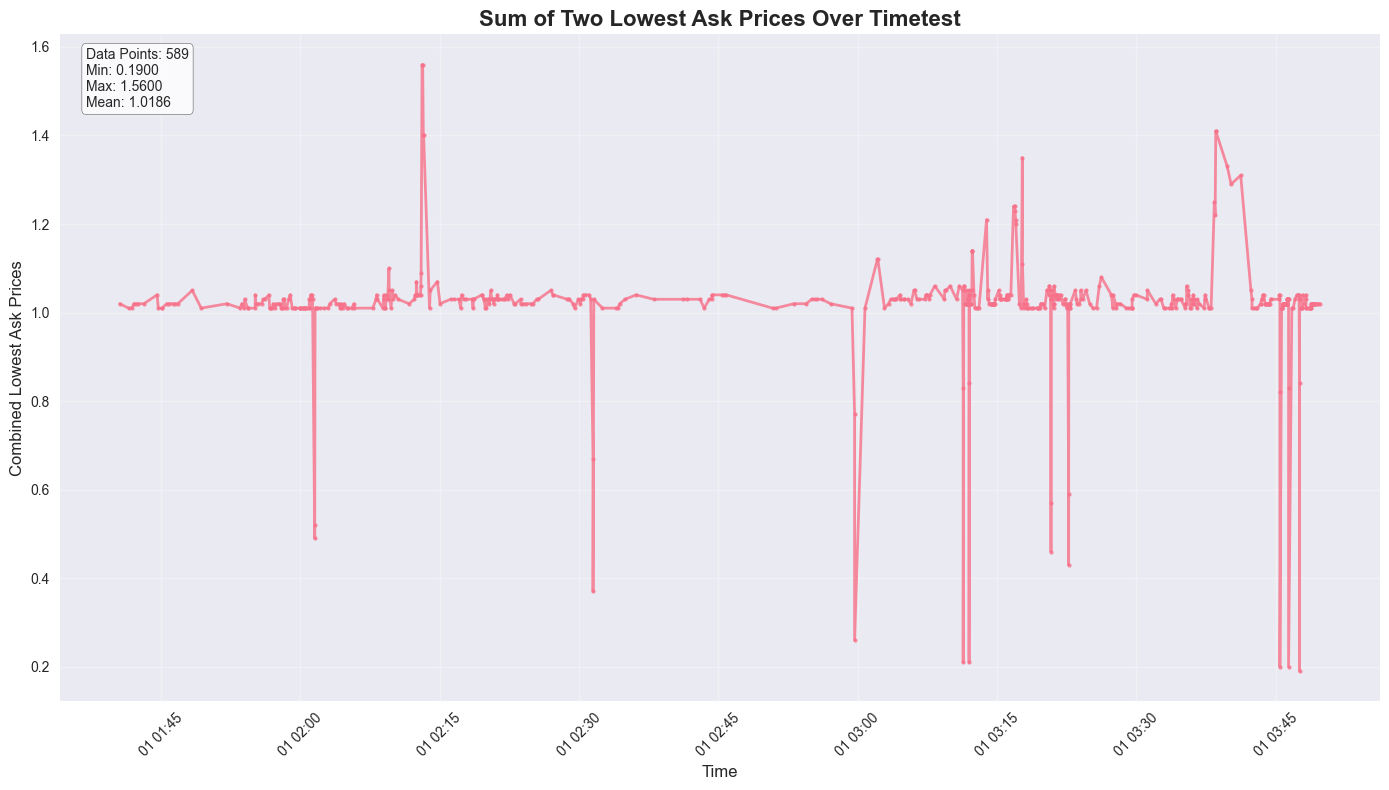

In [6]:
def create_visualization(result_df, title_suffix=""):
    """
    Create a line plot showing the combined lowest ask prices over time.
    
    Args:
        result_df: DataFrame with timestamp and combined_lowest_asks columns
        title_suffix: Additional text for the plot title
    """
    plt.figure(figsize=(14, 8))
    
    # Create the main plot
    plt.plot(result_df['datetime'], result_df['price_sum'], 
             linewidth=2, marker='o', markersize=3, alpha=0.8)
    
    plt.title(f'Sum of Two Lowest Ask Prices Over Time{title_suffix}', fontsize=16, fontweight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Combined Lowest Ask Prices', fontsize=12)
    
    # Improve x-axis formatting
    plt.xticks(rotation=45)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Add some statistics as text
    stats_text = f"""Data Points: {len(result_df)}
Min: {result_df['price_sum'].min():.4f}
Max: {result_df['price_sum'].max():.4f}
Mean: {result_df['price_sum'].mean():.4f}"""
    
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

create_visualization(a, "test")

In [7]:
def process_all_files(file_list, max_files=None):
    """
    Process multiple polymarket events files and combine results.
    
    Args:
        file_list: List of file paths to process
        max_files: Maximum number of files to process (None for all)
        
    Returns:
        dict: Dictionary with filename as key and result DataFrame as value
    """
    all_results = {}
    
    files_to_process = file_list[:max_files] if max_files else file_list
    
    for i, file_path in enumerate(files_to_process):
        print(f"Processing file {i+1}/{len(files_to_process)}: {os.path.basename(file_path)}")
        
        # Load and filter data
        book_data = load_and_filter_data(file_path)
        
        if not book_data.empty:
            # Calculate lowest ask prices
            result = get_lowest_ask_prices_by_timestamp(book_data)
            all_results[os.path.basename(file_path)] = result
            
            print(f"  -> Generated {len(result)} data points\n")
        else:
            print(f"  -> No valid data found\n")
    
    return all_results

# Process first 3 files as an example (you can change this number or remove the limit)
print("Processing multiple files...")
all_results = process_all_files(files, max_files=8)

print(f"\nProcessed {len(all_results)} files successfully:")
for filename, result_df in all_results.items():
    print(f"  - {filename}: {len(result_df)} data points")

Processing multiple files...
Processing file 1/2: 20250630_mlb-sf-ari-2025-06-30_polymarket-market-events.csv
Loaded 71096 total rows, 16348 book ask events from 20250630_mlb-sf-ari-2025-06-30_polymarket-market-events.csv
  -> Generated 589 data points

Processing file 2/2: 20250630_mlb-kc-sea-2025-06-30_polymarket-market-events.csv
Loaded 47625 total rows, 8340 book ask events from 20250630_mlb-kc-sea-2025-06-30_polymarket-market-events.csv
  -> Generated 288 data points


Processed 2 files successfully:
  - 20250630_mlb-sf-ari-2025-06-30_polymarket-market-events.csv: 589 data points
  - 20250630_mlb-kc-sea-2025-06-30_polymarket-market-events.csv: 288 data points



=== Visualization for 20250630_mlb-sf-ari-2025-06-30_polymarket-market-events.csv ===


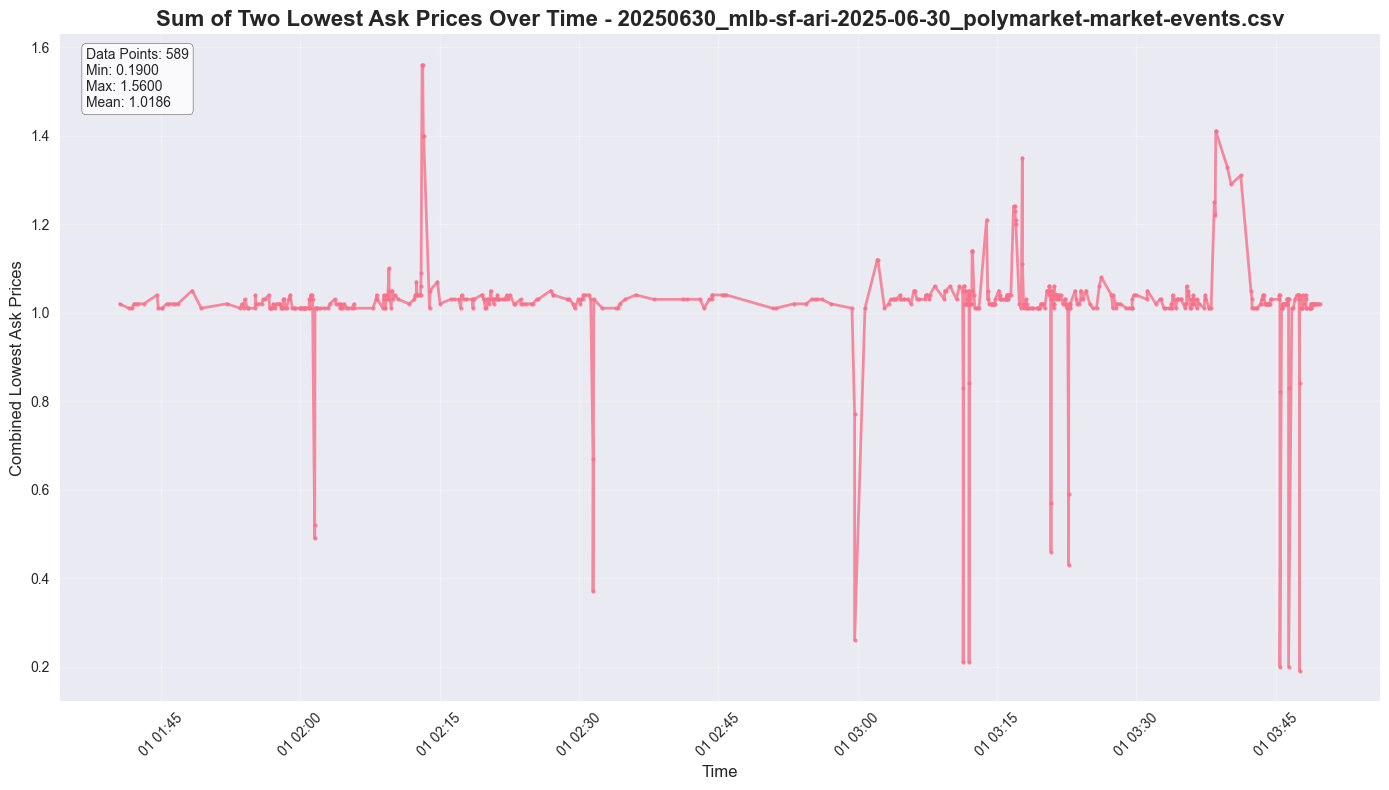


=== Visualization for 20250630_mlb-kc-sea-2025-06-30_polymarket-market-events.csv ===


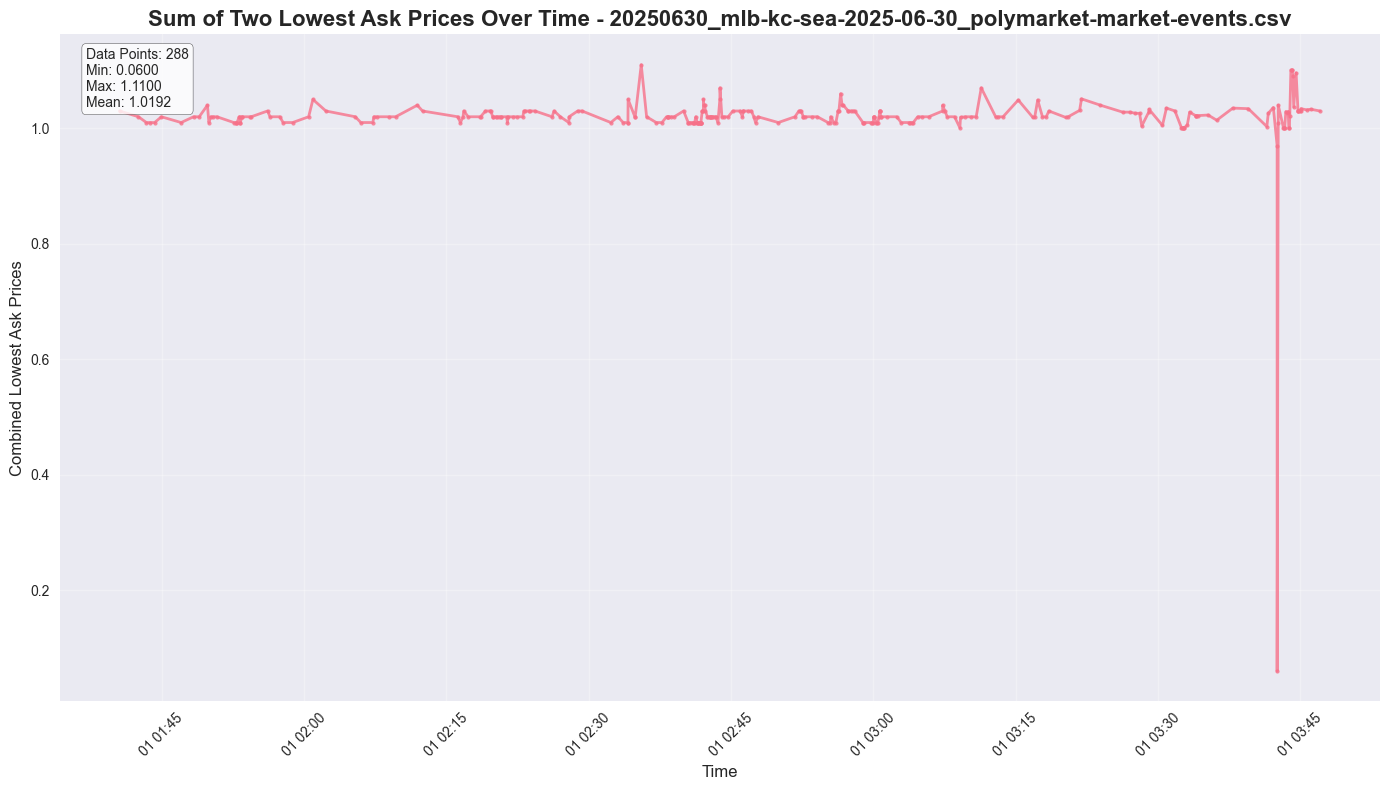

In [8]:
# Create individual plots for each file
for filename, result_df in all_results.items():
    if not result_df.empty:
        print(f"\n=== Visualization for {filename} ===")
        create_visualization(result_df, f" - {filename}")

In [9]:
# Optional: Combine all results into a single plot for comparison
if len(all_results) > 1:f
    plt.figure(figsize=(16, 10))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_results)))
    
    for i, (filename, result_df) in enumerate(all_results.items()):
        if not result_df.empty and '20250619' in filename:
            plt.plot(result_df['datetime'], result_df['price_sum'], 
                    linewidth=2, marker='o', markersize=2, alpha=0.7, 
                    label=filename.replace('-polymarket_market_events.csv', ''), 
                    color=colors[i])
    
    plt.title('Combined View: Sum of Two Lowest Ask Prices Over Time', fontsize=16, fontweight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Combined Lowest Ask Prices', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    print("\nCombined visualization created!")

IndentationError: unexpected indent (2801841164.py, line 3)

In [ ]:
# Summary analysis
print("=== SUMMARY ANALYSIS ===")
print(f"Total files processed: {len(all_results)}")

all_stats = []
for filename, result_df in all_results.items():
    if not result_df.empty:
        stats = {
            'filename': filename,
            'data_points': len(result_df),
            'min_price': result_df['price_sum'].min(),
            'max_price': result_df['price_sum'].max(),
            'mean_price': result_df['price_sum'].mean(),
            'std_price': result_df['price_sum'].std(),
        }
        all_stats.append(stats)

if all_stats:
    summary_df = pd.DataFrame(all_stats)
    print("\nSummary Statistics:")
    print(summary_df.to_string(index=False, float_format='%.4f'))
    
    # Overall statistics
    print(f"\nOverall Statistics:")
    print(f"Total data points across all files: {summary_df['data_points'].sum()}")
    print(f"Average data points per file: {summary_df['data_points'].mean():.1f}")
else:
    print("No valid data found in any files.")

# Synthetic Order Book Analysis

Now we'll analyze the synthetic order book files (`...order_book.csv`) to identify arbitrage opportunities. 
This analysis should show more opportunities than the Market Events analysis above since we capture price changes more frequently.

In [ ]:
# Get all synthetic order book files
order_book_pattern = "2025062*synthetic_orders.csv"
order_book_files = glob.glob(os.path.join(data_path, order_book_pattern))

print(f"Found {len(order_book_files)} synthetic order book files:")
for file in order_book_files[:5]:  # Show first 5 files
    print(f"  - {os.path.basename(file)}")
if len(order_book_files) > 5:
    print(f"  ... and {len(order_book_files) - 5} more files")

In [ ]:
def load_synthetic_order_book(file_path):
    """
    Load a synthetic order book CSV file and filter for ask side orders.
    
    Returns:
        pd.DataFrame: Filtered dataframe with ask side orders only
    """
    try:
        # Load the CSV file
        df = pd.read_csv(file_path)
        
        # Filter for ask side only
        ask_orders = df[df['side'] == 'ask'].copy()
        
        # Convert timestamp to datetime for easier analysis
        ask_orders['datetime'] = pd.to_datetime(ask_orders['timestamp'], unit='ms')
        ask_orders['timestamp_id'] = ask_orders['timestamp']
        
        print(f"Loaded {len(df)} total rows, {len(ask_orders)} ask orders from {os.path.basename(file_path)}")
        
        return ask_orders
    
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return pd.DataFrame()

# Test with the first file
if order_book_files:
    test_order_book = load_synthetic_order_book(order_book_files[0])
    print(f"\nSample synthetic order book data:")
    print(test_order_book.head())
    print(f"\nUnique asset_ids: {test_order_book['asset_id'].nunique()}")
    print(f"Unique timestamps: {test_order_book['timestamp'].nunique()}")
    print(f"Unique outcome_names: {test_order_book['outcome_name'].unique()}")

In [ ]:
def create_order_book_summary(group_df):
    """
    For each timestamp group, create a summary object with:
    - sum of minimum ask prices for each asset_id
    - minimum price and size for each asset
    """
    # Group by asset_id within this timestamp group and get the row with minimum price for each asset_id
    asset_groups = group_df.groupby('asset_id')
    min_p_rows = asset_groups.apply(lambda x: x.loc[x['price'].idxmin()], include_groups=False)
    
    result = {}
    
    # Get minimum price values for each asset
    min_p_values = []
    for asset_id, row in min_p_rows.iterrows():
        result['market_slug'] = row['market_slug']
        result['datetime'] = row['datetime']
        result['timestamp'] = row['timestamp']
        # Use last 4 characters of asset_id as identifier
        result[f'price_{asset_id[-4:]}'] = row['price']
        result[f'size_{asset_id[-4:]}'] = row['size']
        result[f'outcome_{asset_id[-4:]}'] = row['outcome_name']
        
        min_p_values.append(row['price'])

    result['price_sum'] = sum(min_p_values)
    return result

def get_synthetic_order_book_arb_opportunities(df):
    """Calculate arbitrage opportunities from synthetic order book data."""
    x = df.groupby('timestamp_id').apply(create_order_book_summary, include_groups=False)
    return pd.json_normalize(x)

# Test with first file
if order_book_files and not test_order_book.empty:
    order_book_arb = get_synthetic_order_book_arb_opportunities(test_order_book)
    print(f"Found {len(order_book_arb)} timestamp groups")
    print(f"\nSample arbitrage data:")
    print(order_book_arb.head())
    
    # Show opportunities where sum < 1
    opportunities = order_book_arb[order_book_arb['price_sum'] < 1.0]
    print(f"\nFound {len(opportunities)} arbitrage opportunities (sum < $1)")
    if not opportunities.empty:
        print(opportunities[['datetime', 'price_sum']].head())

In [ ]:
# Create visualization for synthetic order book data
if order_book_files and not test_order_book.empty:
    create_visualization(order_book_arb, " - Synthetic Order Book")
    
    # Highlight arbitrage opportunities
    plt.figure(figsize=(14, 8))
    
    # Plot all data points
    plt.plot(order_book_arb['datetime'], order_book_arb['price_sum'], 
             linewidth=2, marker='o', markersize=3, alpha=0.6, label='Sum of Lowest Asks')
    
    # Highlight opportunities (sum < 1.0) in red
    opportunities = order_book_arb[order_book_arb['price_sum'] < 1.0]
    if not opportunities.empty:
        plt.scatter(opportunities['datetime'], opportunities['price_sum'], 
                   color='red', s=50, zorder=5, label=f'Arbitrage Opportunities (n={len(opportunities)})')
    
    # Add horizontal line at y=1
    plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.7, label='Break-even threshold ($1)')
    
    plt.title('Synthetic Order Book: Arbitrage Opportunities', fontsize=16, fontweight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Sum of Lowest Ask Prices', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def process_all_order_book_files(file_list, max_files=None):
    """
    Process multiple synthetic order book files and combine results.
    
    Args:
        file_list: List of file paths to process
        max_files: Maximum number of files to process (None for all)
        
    Returns:
        dict: Dictionary with filename as key and result DataFrame as value
    """
    all_results = {}
    
    files_to_process = file_list[:max_files] if max_files else file_list
    
    for i, file_path in enumerate(files_to_process):
        print(f"\nProcessing file {i+1}/{len(files_to_process)}: {os.path.basename(file_path)}")
        
        # Load and filter data
        order_book_data = load_synthetic_order_book(file_path)
        
        if not order_book_data.empty:
            # Calculate arbitrage opportunities
            result = get_synthetic_order_book_arb_opportunities(order_book_data)
            all_results[os.path.basename(file_path)] = result
            
            # Calculate statistics
            opportunities = result[result['price_sum'] < 1.0]
            
            print(opportunities[['market_slug', 'timestamp', 'price_sum']])
                
            print(f"  -> Generated {len(result)} data points")
            print(f"  -> Found {len(opportunities)} arbitrage opportunities ({len(opportunities)/len(result)*100:.1f}%)")
        else:
            print(f"  -> No valid data found")
    
    return all_results

# Process synthetic order book files
print("Processing synthetic order book files...")
order_book_results = process_all_order_book_files(order_book_files, max_files=8)

print(f"\n\nProcessed {len(order_book_results)} synthetic order book files successfully")

In [ ]:
# Create individual plots for each synthetic order book file
for filename, result_df in order_book_results.items():
    if not result_df.empty:
        print(f"\n=== Visualization for {filename} ===")
        
        plt.figure(figsize=(14, 8))
        
        # Plot all data points
        plt.plot(result_df['datetime'], result_df['price_sum'], 
                 linewidth=2, marker='o', markersize=3, alpha=0.6, label='Sum of Lowest Asks')
        
        # Highlight opportunities (sum < 1.0) in red
        opportunities = result_df[result_df['price_sum'] < 1.0]
        if not opportunities.empty:
            plt.scatter(opportunities['datetime'], opportunities['price_sum'], 
                       color='red', s=50, zorder=5, label=f'Arbitrage Opportunities (n={len(opportunities)})')
        
        # Add horizontal line at y=1
        plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.7, label='Break-even threshold ($1)')
        
        plt.title(f'Synthetic Order Book: {filename}', fontsize=14, fontweight='bold')
        plt.xlabel('Time', fontsize=12)
        plt.ylabel('Sum of Lowest Ask Prices', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add statistics text
        stats_text = f"""Data Points: {len(result_df)}
Opportunities: {len(opportunities)} ({len(opportunities)/len(result_df)*100:.1f}%)
Min Sum: {result_df['price_sum'].min():.4f}
Max Sum: {result_df['price_sum'].max():.4f}"""
        
        plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

## Comparison: Market Events vs Synthetic Order Book

Let's compare the arbitrage opportunities found in both data sources by overlaying the graphs.

In [ ]:
# Find matching files between market events and synthetic order book
matching_games = []

for market_file in all_results.keys():
    # Extract game identifier from market events filename
    game_id = market_file.replace('-polymarket_market_events.csv', '')
    
    # Look for corresponding order book file
    order_book_file = f"{game_id}-order_book.csv"
    
    if order_book_file in order_book_results:
        matching_games.append((game_id, market_file, order_book_file))

print(f"Found {len(matching_games)} matching game pairs")
for game_id, market_file, order_book_file in matching_games:
    print(f"  - {game_id}")

# Create overlay plots for matching games
for game_id, market_file, order_book_file in matching_games[:3]:  # Show first 3 matches
    market_df = all_results[market_file]
    order_book_df = order_book_results[order_book_file]
    
    if not market_df.empty and not order_book_df.empty:
        plt.figure(figsize=(16, 10))
        
        # Plot market events data
        plt.plot(market_df['datetime'], market_df['price_sum'], 
                 linewidth=2, marker='o', markersize=4, alpha=0.7, 
                 label='Market Events (book events only)', color='blue')
        
        # Plot synthetic order book data
        plt.plot(order_book_df['datetime'], order_book_df['price_sum'], 
                 linewidth=2, marker='s', markersize=3, alpha=0.6, 
                 label='Synthetic Order Book', color='orange')
        
        # Highlight opportunities from both sources
        market_opps = market_df[market_df['price_sum'] < 1.0]
        order_book_opps = order_book_df[order_book_df['price_sum'] < 1.0]
        
        if not market_opps.empty:
            plt.scatter(market_opps['datetime'], market_opps['price_sum'], 
                       color='darkblue', s=80, zorder=5, marker='o',
                       label=f'Market Events Opportunities (n={len(market_opps)})')
        
        if not order_book_opps.empty:
            plt.scatter(order_book_opps['datetime'], order_book_opps['price_sum'], 
                       color='red', s=60, zorder=5, marker='s',
                       label=f'Order Book Opportunities (n={len(order_book_opps)})')
        
        # Add horizontal line at y=1
        plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.7, 
                   label='Break-even threshold ($1)')
        
        plt.title(f'Comparison: {game_id}', fontsize=16, fontweight='bold')
        plt.xlabel('Time', fontsize=12)
        plt.ylabel('Sum of Lowest Ask Prices', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add comparison statistics
        stats_text = f"""Market Events: {len(market_df)} points, {len(market_opps)} opportunities
Synthetic Order Book: {len(order_book_df)} points, {len(order_book_opps)} opportunities
Order Book captures {len(order_book_df)/len(market_df):.1f}x more data points"""
        
        plt.text(0.02, 0.02, stats_text, transform=plt.gca().transAxes, 
                 verticalalignment='bottom', 
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

In [ ]:
# Summary comparison statistics
print("=== OVERALL COMPARISON ===\n")

# Collect statistics for both data sources
market_stats = []
order_book_stats = []

for game_id, market_file, order_book_file in matching_games:
    market_df = all_results[market_file]
    order_book_df = order_book_results[order_book_file]
    
    if not market_df.empty and not order_book_df.empty:
        market_opps = market_df[market_df['price_sum'] < 1.0]
        order_book_opps = order_book_df[order_book_df['price_sum'] < 1.0]
        
        market_stats.append({
            'game': game_id,
            'data_points': len(market_df),
            'opportunities': len(market_opps),
            'opp_rate': len(market_opps) / len(market_df) * 100 if len(market_df) > 0 else 0
        })
        
        order_book_stats.append({
            'game': game_id,
            'data_points': len(order_book_df),
            'opportunities': len(order_book_opps),
            'opp_rate': len(order_book_opps) / len(order_book_df) * 100 if len(order_book_df) > 0 else 0
        })

if market_stats and order_book_stats:
    market_summary = pd.DataFrame(market_stats)
    order_book_summary = pd.DataFrame(order_book_stats)
    
    print("Market Events Summary:")
    print(f"  Total data points: {market_summary['data_points'].sum()}")
    print(f"  Total opportunities: {market_summary['opportunities'].sum()}")
    print(f"  Average opportunity rate: {market_summary['opp_rate'].mean():.1f}%")
    
    print("\nSynthetic Order Book Summary:")
    print(f"  Total data points: {order_book_summary['data_points'].sum()}")
    print(f"  Total opportunities: {order_book_summary['opportunities'].sum()}")
    print(f"  Average opportunity rate: {order_book_summary['opp_rate'].mean():.1f}%")
    
    print(f"\nData Coverage Improvement:")
    print(f"  Synthetic Order Book captures {order_book_summary['data_points'].sum() / market_summary['data_points'].sum():.1f}x more data points")
    print(f"  Synthetic Order Book finds {order_book_summary['opportunities'].sum() / market_summary['opportunities'].sum():.1f}x more opportunities")